In [1]:
# Used on Kaggle to install gower each time
#!pip install gower

  Created wheel for gower: filename=gower-0.0.5-py3-none-any.whl size=4231 sha256=c078c87627201ed4e1825e38d4eb16b2457e3b5cc89e1f38226e60cf733236c8
  Stored in directory: /root/.cache/pip/wheels/3e/f9/9a/67122a959a424e9cbb4557a8366c871a30e31cd75f0d003db4
Successfully built gower
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
# Import statements

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import gower
import time

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from numpy.random import seed
from numpy.random import rand
from sklearn.model_selection import RandomizedSearchCV
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

''' Used for Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Matplotlib is building the font cache; this may take a moment.


" Used for Kaggle\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
# Gets used everywhere so putting at the top - just computes accuracy of a model in the standard sense
def accuracy(predict, label):
    cm = confusion_matrix(label, predict)
    return sum(np.diag(cm))/cm.sum()

# Read in data, parse it
train_set = pd.read_csv('./train.csv')
test_set = pd.read_csv('./test.csv')

X_train = train_set.iloc[:,:len(train_set.columns)-1]
y_train = train_set.iloc[:,len(train_set.columns)-1:]
X_test = test_set

# Initialize KFold object to be used throughout remaining code
kf = KFold(n_splits = 5)

# Drop some features that don't seem useful - is_business_travel_ready only has one value, id is unrelated
X_train = X_train.drop(columns = ['is_business_travel_ready', 'id'])
X_test = X_test.drop(columns = ['is_business_travel_ready', 'id'])

# Clean out datetime features and replace each datetime with number of months elapsed from that datetime
# to the last datetime in the list
X_train['host_since']= pd.to_datetime(X_train['host_since'])
X_train['last_review']= pd.to_datetime(X_train['last_review'])

max_host_date = X_train.host_since.max()
max_review_date = X_train.last_review.max()

X_train['num_months_since_host'] = X_train['host_since'].transform(lambda x: 12 * (max_host_date.year - x.year) + (max_host_date.month - x.month))
X_train['num_months_since_last_review'] = X_train['last_review'].transform(lambda x: 12 * (max_review_date.year - x.year) + (max_review_date.month - x.month))
X_train = X_train.drop(columns = ['host_since', 'last_review'])

X_test['host_since']= pd.to_datetime(X_test['host_since'])
X_test['last_review']= pd.to_datetime(X_test['last_review'])

max_host_date = X_test.host_since.max()
max_review_date = X_test.last_review.max()

X_test['num_months_since_host'] = X_test['host_since'].transform(lambda x: 12 * (max_host_date.year - x.year) + (max_host_date.month - x.month))
X_test['num_months_since_last_review'] = X_test['last_review'].transform(lambda x: 12 * (max_review_date.year - x.year) + (max_review_date.month - x.month))
X_test = X_test.drop(columns = ['host_since', 'last_review'])

In [3]:
# Intuitively, values within certain ranges should be equivalent - we can manually set where these cutoffs should be
# Don't do this with features that are already reasonable - only for those where the values are largely the same or there are outliers
# Helps make the distances in the gower distance more reasonable
coarse_X_train = X_train.copy()
coarse_X_train['binned_min_nights'] = pd.to_numeric(pd.cut(coarse_X_train['minimum_nights'], bins=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,21,28,35,42,60,90, 120, 150, 180, 365, coarse_X_train.minimum_nights.max()], labels= range(26)))
coarse_X_train['binned_num_reviews'] = pd.to_numeric(pd.cut(coarse_X_train['number_of_reviews'], bins=[-1, 0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120,140,160,180,200,225,250,275,300,333,367,400,450,500,coarse_X_train.number_of_reviews.max()], labels = range(38), duplicates = 'drop'))
coarse_X_train['binned_last_review'] = pd.to_numeric(pd.cut(coarse_X_train['num_months_since_last_review'], bins=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,14,16,18,20,22,24,27,30,33,36,40,44,48,54,60,66,72,78,84,96,108,coarse_X_train.num_months_since_last_review.max()], labels= range(35)))
coarse_X_train['binned_host_listings'] = pd.to_numeric(pd.cut(coarse_X_train['calculated_host_listings_count'], bins=[-1,0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,75, 100, coarse_X_train.calculated_host_listings_count.max()], labels= range(20)))
coarse_X_train['binned_availability_365'] = pd.to_numeric(pd.cut(coarse_X_train['availability_365'], bins = [-1,0,7,14,30,60,90, 120,150, 180,240,300,330,350,coarse_X_train.availability_365.max()], labels = range(14)))
coarse_X_train['binned_host_since'] = pd.to_numeric(pd.cut(coarse_X_train['num_months_since_host'], bins = [-1,0,1,2,3,4,5,6,7,8,9,10,11,12,14,16,18,20,22,24,27,30,33,36,40,44,48,54,60,66,72,78,84,96,108,120,132,coarse_X_train.num_months_since_host.max()], labels = range(37)))
coarse_X_train['binned_extra_people'] = pd.to_numeric(pd.cut(coarse_X_train['extra_people'], bins = [-1,0,100,200,300,400,500,600,700,800,900,1000,1250,1500,1750,2000,3000,4000,5000,10000,coarse_X_train.extra_people.max()], labels = range(20)))
coarse_X_train['binned_maximum_nights'] = pd.to_numeric(pd.cut(coarse_X_train['maximum_nights'], bins = [-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,21,30,60,90,120,150,180,365,730,1095,1460,1825,coarse_X_train.maximum_nights.max()], labels = range(28)))
coarse_X_train = coarse_X_train.drop(columns = ['minimum_nights', 'number_of_reviews', 'num_months_since_last_review', 'calculated_host_listings_count', 'availability_365', 'num_months_since_host', 'extra_people', 'maximum_nights'])


No handles with labels found to put in legend.


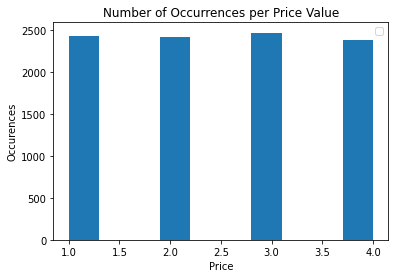

In [4]:
# The dataset is balanced as you can see
plt.xlabel("Price")
plt.ylabel("Occurences")
plt.hist(train_set.price)
plt.title("Number of Occurrences per Price Value")
plt.legend()
plt.show()


c:\python39\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


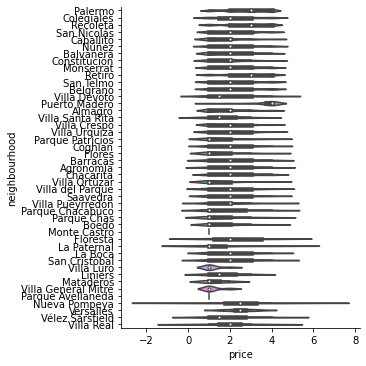

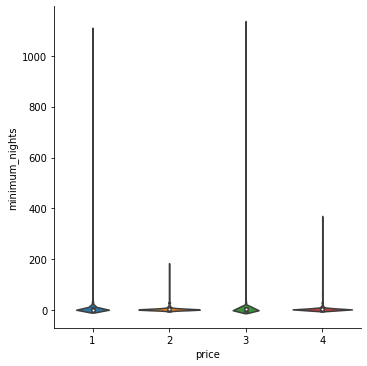

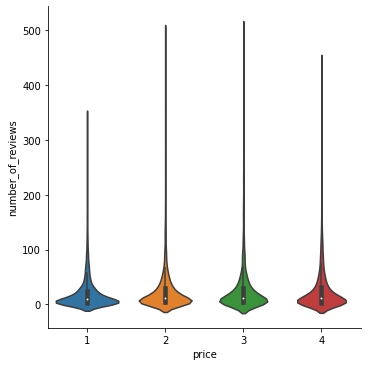

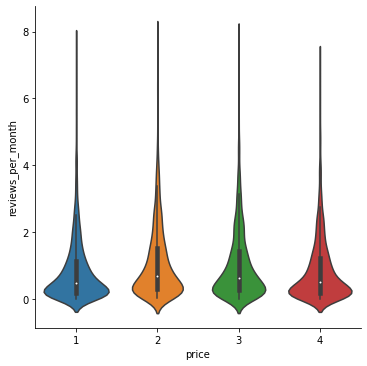

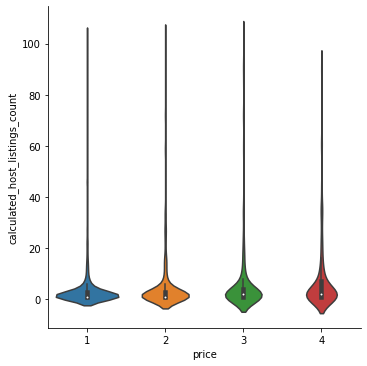

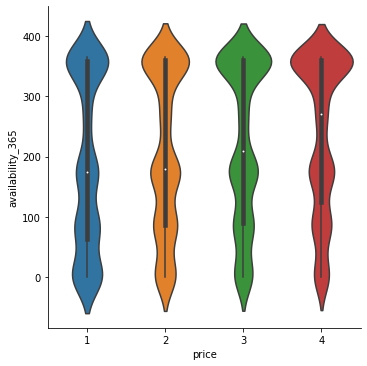

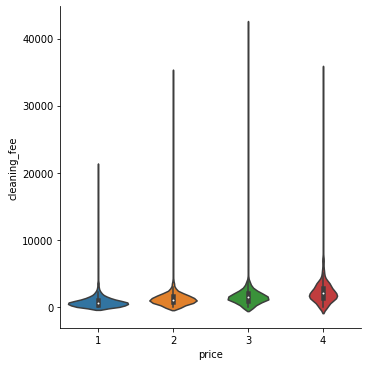

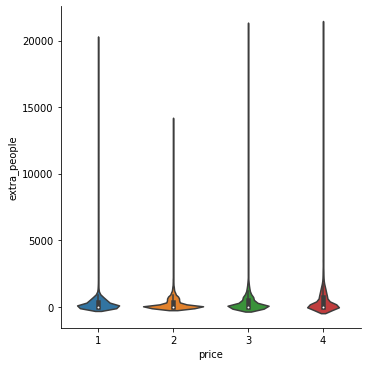

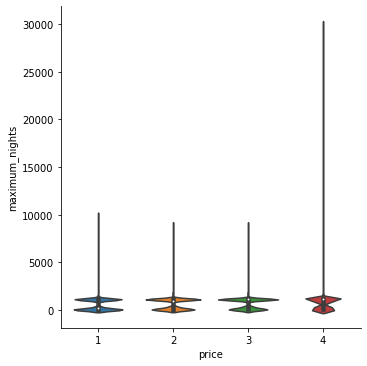

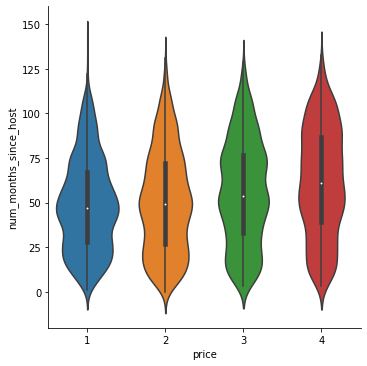

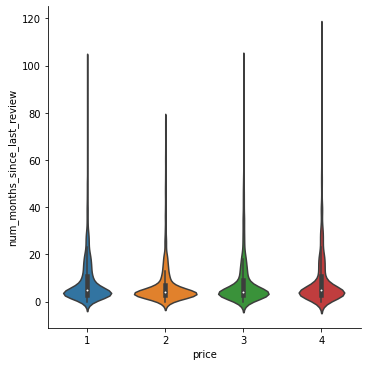

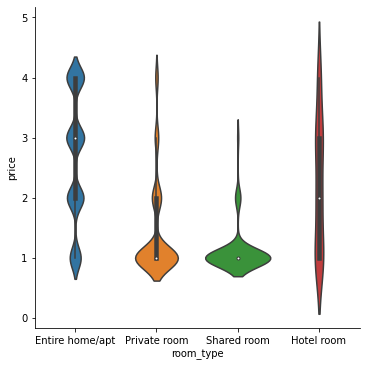

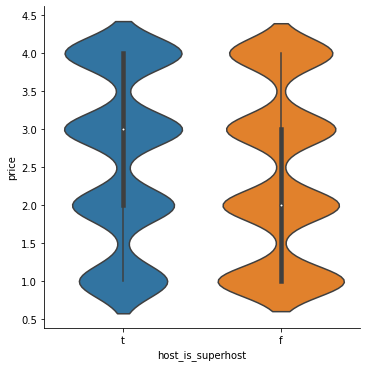

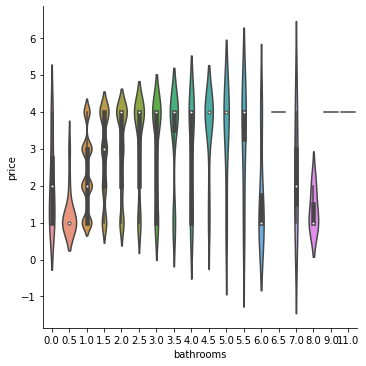

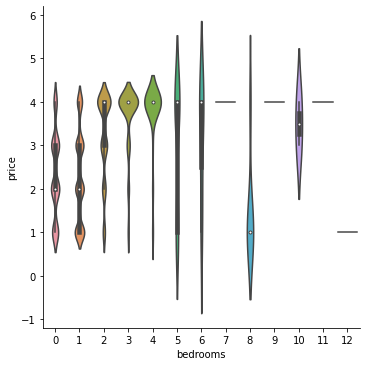

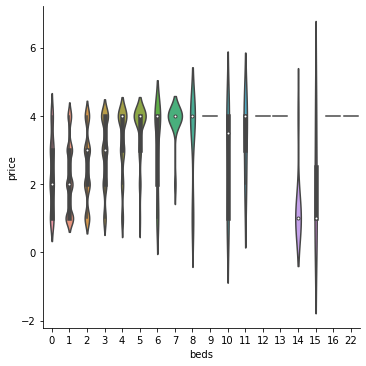

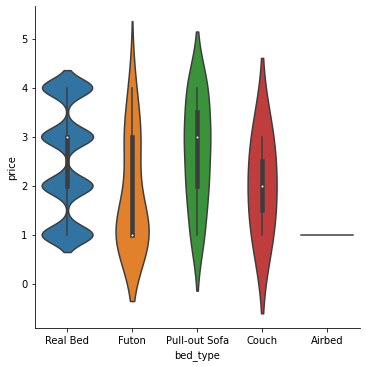

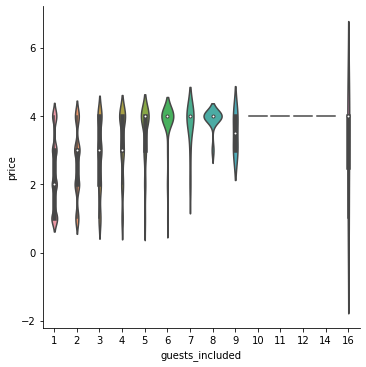

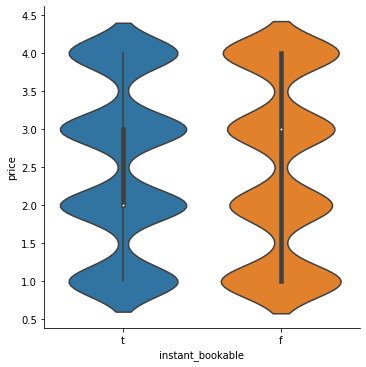

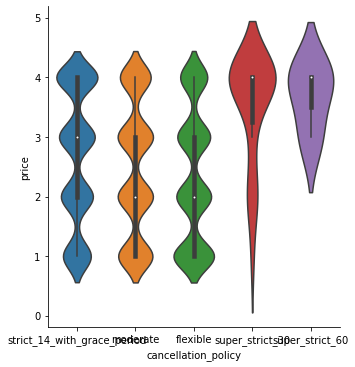

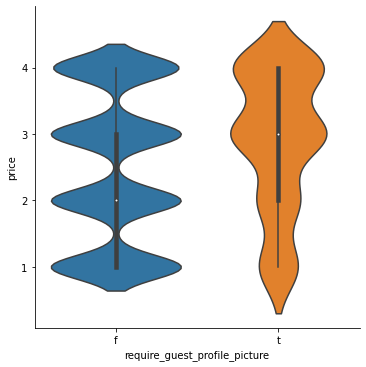

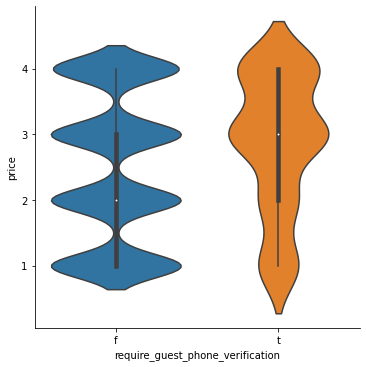

In [5]:
# Make violin plots for all variables

train_set["num_months_since_host"] = X_train["num_months_since_host"]
train_set["num_months_since_last_review"] = X_train["num_months_since_last_review"]

price_on_x_columns = ['neighbourhood', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                     'calculated_host_listings_count', 'availability_365', 'cleaning_fee','extra_people', 'maximum_nights',
                     'num_months_since_host', 'num_months_since_last_review']
price_on_y_columns = ['room_type', 'host_is_superhost', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 
                      'guests_included', 'instant_bookable', 'cancellation_policy',
                     'require_guest_profile_picture', 'require_guest_phone_verification']

# Plot price on x when the column has too many unique values
for column in price_on_x_columns:
    sns.catplot(x="price", y=column, kind="violin", data=train_set)

# Plot price on y when we can, since this corresponds more naturally with what we would want to see
for column in price_on_y_columns:
    sns.catplot(x=column, y="price", kind="violin", data=train_set)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


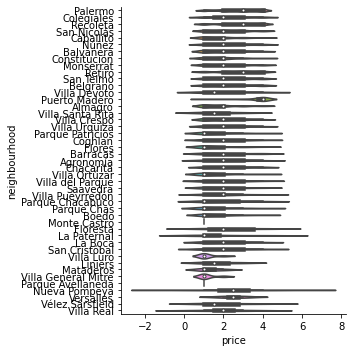

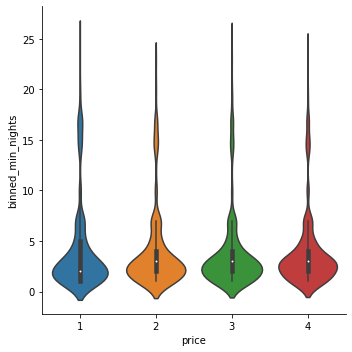

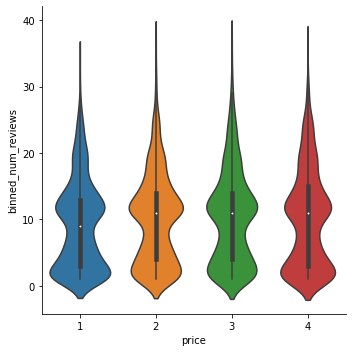

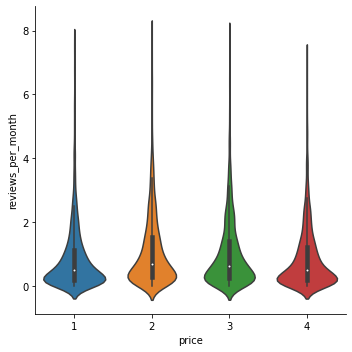

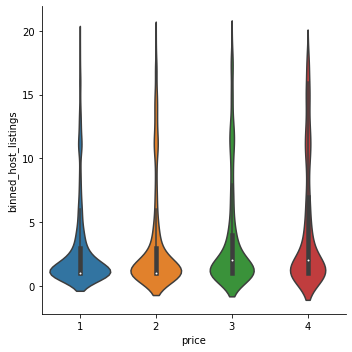

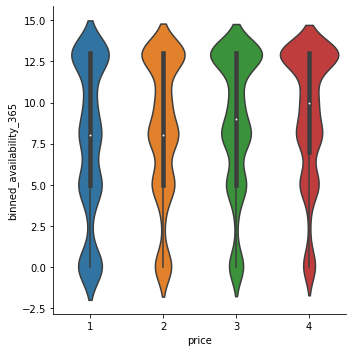

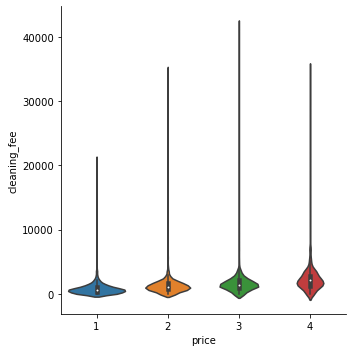

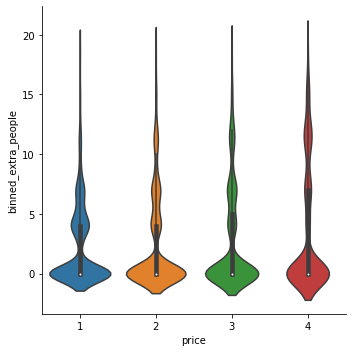

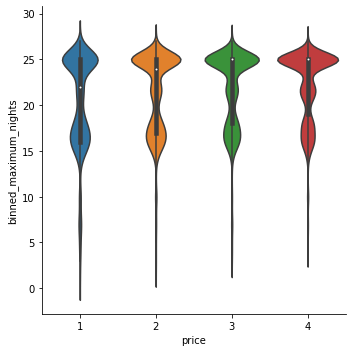

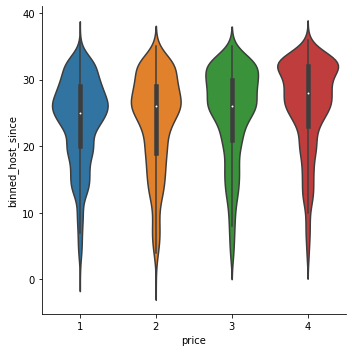

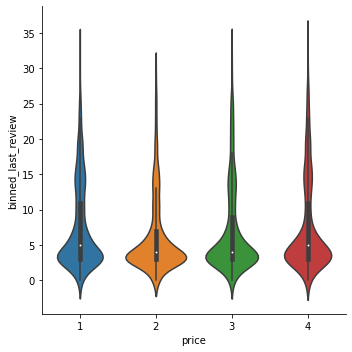

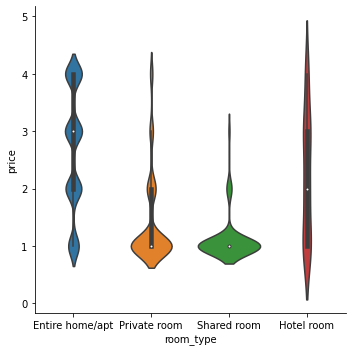

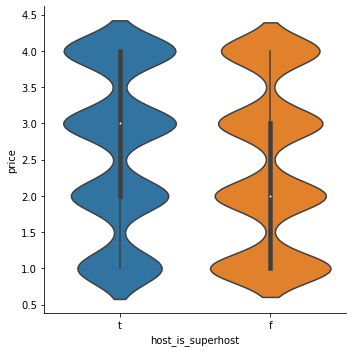

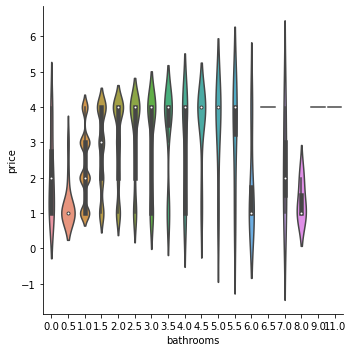

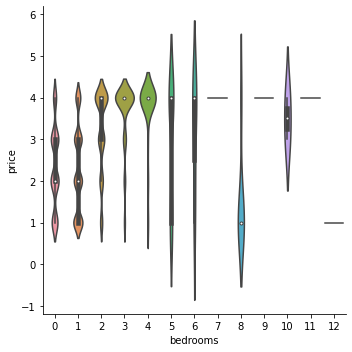

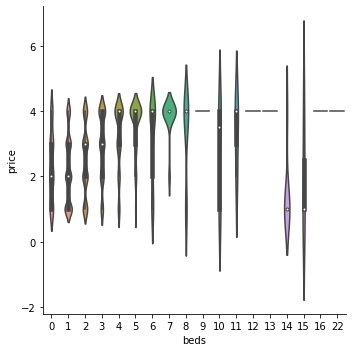

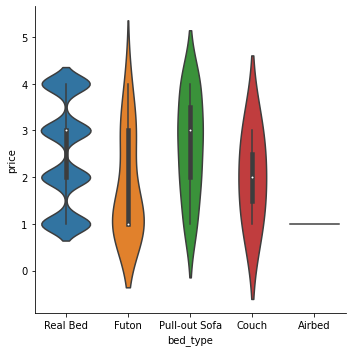

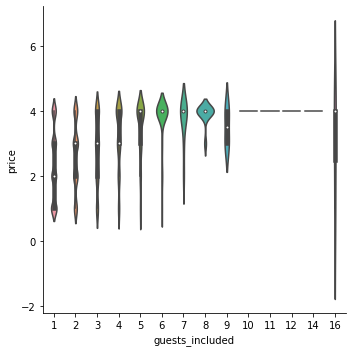

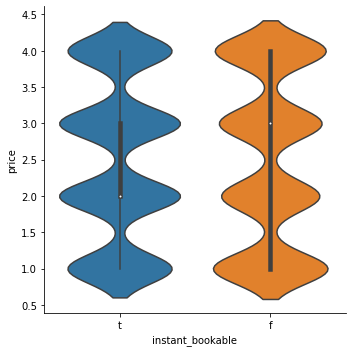

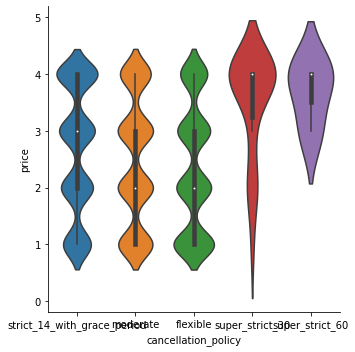

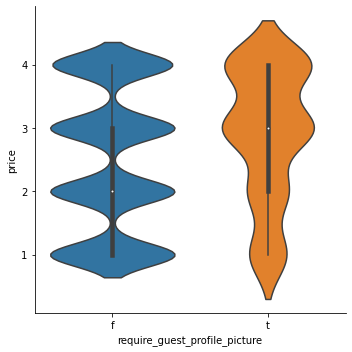

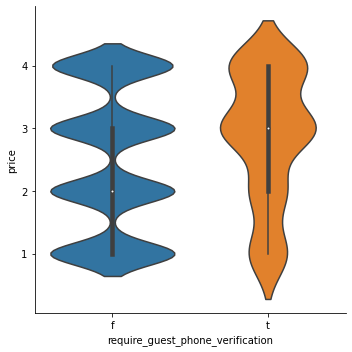

In [7]:
# Same thing but now on the binned data
price_on_x_columns = ['neighbourhood', 'binned_min_nights', 'binned_num_reviews', 'reviews_per_month',
                     'binned_host_listings', 'binned_availability_365', 'cleaning_fee','binned_extra_people', 'binned_maximum_nights',
                     'binned_host_since', 'binned_last_review']
price_on_y_columns = ['room_type', 'host_is_superhost', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 
                      'guests_included', 'instant_bookable', 'cancellation_policy',
                     'require_guest_profile_picture', 'require_guest_phone_verification']

coarse_X_train['price'] = train_set['price']

# Plot price on x when the column has too many unique values
for column in price_on_x_columns:
    sns.catplot(x="price", y=column, kind="violin", data=coarse_X_train)

# Plot price on y when we can, since this corresponds more naturally with what we would want to see
for column in price_on_y_columns:
    sns.catplot(x=column, y="price", kind="violin", data=coarse_X_train)
    
coarse_X_train = coarse_X_train.drop(columns = 'price')

Some of the most distinguishing features look like room_type, bathrooms, bedrooms, beds, bed_type, cancellation_policy, require_guest_profile_picture, and require_guest_phone_verification.

In [8]:
# Make categorical variables into ordinal variables
# Variables which are categorical: ID, Neighborhood, Room Type, Last Review, Bed Type
# Variables that you probably want to bracket: Minimum Nights, Number of Reviews, Reviews per month, host listings count, availability 365, Host since, cleaning fee

# Minimal working way to turn categorical variables into numerical - just directly apply ordinal encoding
lazy_encoder = OrdinalEncoder()
lazy_encoder.fit(X_train)
lazy_X_train = lazy_encoder.transform(X_train)

# Another ordinal encoder - this time we specify the order in which values for each feature should be ordered,
# based on intuition and the violin plots above. Order matters in encoding since we will use random forest
# which will choose splits along the order in which values have been given
smart_encoder = OrdinalEncoder(categories = [
    # neighbourhood - no sorting performed
    X_train.neighbourhood.unique(),
    # room_type
    ["Shared room", "Private room", "Hotel room", "Entire home/apt"], 
    # minimum_nights
    np.sort(X_train.minimum_nights.unique()),
    # number_of_reviews
    np.sort(X_train.number_of_reviews.unique()),
    # reviews_per_month
    np.sort(X_train.reviews_per_month.unique()),
    # calculated_host_listings_count
    np.sort(X_train.calculated_host_listings_count.unique()),
    # availability_365
    np.sort(X_train.availability_365.unique()),
    # host_is_superhost
    ['f', 't'],
    # bathrooms
    np.sort(X_train.bathrooms.unique()),
    # bedrooms
    np.sort(X_train.bedrooms.unique()),
    # beds
    np.sort(X_train.beds.unique()),
    # bed_type
    ["Airbed", "Futon", "Couch", "Pull-out Sofa", "Real Bed"],
    # cleaning_fee
    np.sort(X_train.cleaning_fee.unique()),
    # guests_included
    np.sort(X_train.guests_included.unique()),
    # extra_people
    np.sort(X_train.extra_people.unique()),
    # maximum_nights
    np.sort(X_train.maximum_nights.unique()),
    # instant_bookable
    ['f', 't'],
    # cancellation_policy
    ['flexible', 'moderate', 'strict_14_with_grace_period', 'super_strict_30','super_strict_60'],
    # require_guest_profile_picture
    ["f", "t"],
    # require_guest_phone_verification
    ["f","t"],
    # num_months_since_host
    np.sort(X_train.num_months_since_host.unique()),
    # num_months_since_last_review
    np.sort(X_train.num_months_since_last_review.unique())
])

smart_encoder.fit(X_train)
smart_X_train = smart_encoder.transform(X_train)

# We also tried to create some new features from the existing data that might be more predictive - it didn't end up working very well
# There are in fact listings with 0 bedrooms
#print(X_train[X_train['bedrooms']==0])
bed_bath_quotient = X_train["bedrooms"]/X_train["bathrooms"]
# Checked manually that the max quotient would be 12
bed_bath_quotient = bed_bath_quotient.replace(np.inf,13)
bed_bath_quotient = bed_bath_quotient.replace(np.NaN, 14)

bed_room_quotient = X_train["beds"]/X_train["bedrooms"]
# Checked manually that max quotient is 14
bed_room_quotient = bed_room_quotient.replace(np.inf, 15)
bed_room_quotient = bed_room_quotient.replace(np.NaN, 16)

new_X_train = np.concatenate([smart_X_train, bed_bath_quotient.values.reshape(bed_bath_quotient.values.shape[0],-1)], axis = 1)
new_X_train = np.concatenate([smart_X_train, bed_room_quotient.values.reshape(bed_room_quotient.values.shape[0],-1)], axis = 1)


In [9]:
binned_smart_encoder = OrdinalEncoder(categories = [
    # neighbourhood - no sorting performed
    coarse_X_train.neighbourhood.unique(),
    # room_type
    ["Shared room", "Private room", "Hotel room", "Entire home/apt"], 
    # reviews_per_month
    np.sort(coarse_X_train.reviews_per_month.unique()),
    # host_is_superhost
    ['f', 't'],
    # bathrooms
    np.sort(coarse_X_train.bathrooms.unique()),
    # bedrooms
    np.sort(coarse_X_train.bedrooms.unique()),
    # beds
    np.sort(coarse_X_train.beds.unique()),
    # bed_type
    ["Airbed", "Futon", "Couch", "Pull-out Sofa", "Real Bed"],
    # cleaning_fee
    np.sort(coarse_X_train.cleaning_fee.unique()),
    # guests_included
    np.sort(coarse_X_train.guests_included.unique()),
    # instant_bookable
    ['f', 't'],
    # cancellation_policy
    ['flexible', 'moderate', 'strict_14_with_grace_period', 'super_strict_30','super_strict_60'],
    # require_guest_profile_picture
    ["f", "t"],
    # require_guest_phone_verification
    ["f","t"],
    # binned_min_nights
    np.sort(coarse_X_train.binned_min_nights.unique()),
    # binned_num_reviews
    np.sort(coarse_X_train.binned_num_reviews.unique()),
    # binned_last_review
    np.sort(coarse_X_train.binned_last_review.unique()),
    # binned_host_listings
    np.sort(coarse_X_train.binned_host_listings.unique()),
    # binned_availability_365
    np.sort(coarse_X_train.binned_availability_365.unique()),
    # binned_host_since
    np.sort(coarse_X_train.binned_host_since.unique()),
    # binned_extra_people
    np.sort(coarse_X_train.binned_extra_people.unique()),
    # maximum_nights
    np.sort(coarse_X_train.binned_maximum_nights.unique())
])

binned_smart_encoder.fit(coarse_X_train)
binned_X_train = binned_smart_encoder.transform(coarse_X_train)

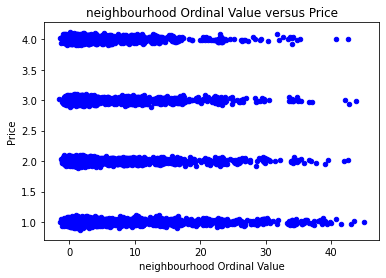

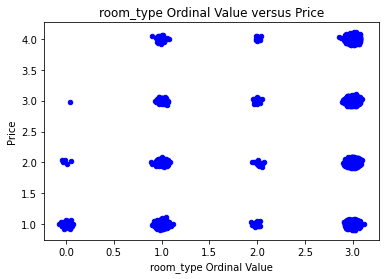

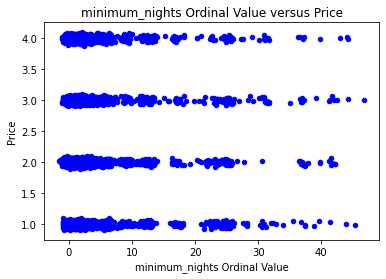

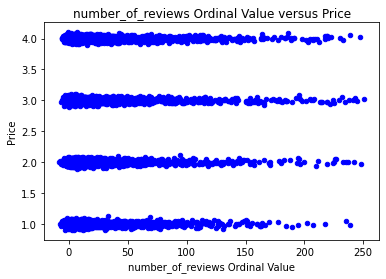

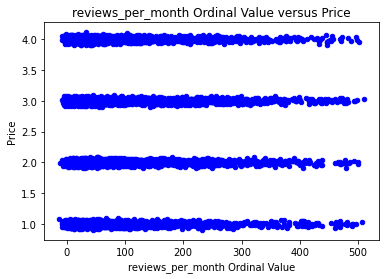

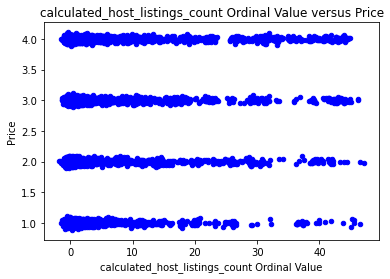

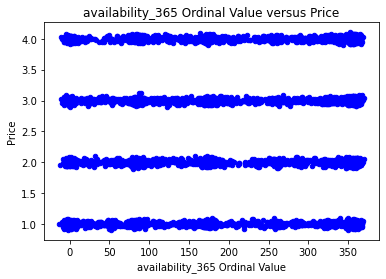

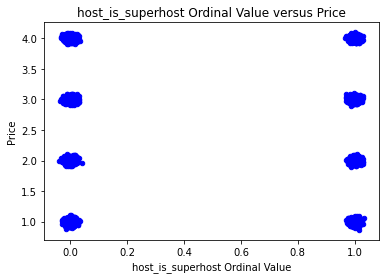

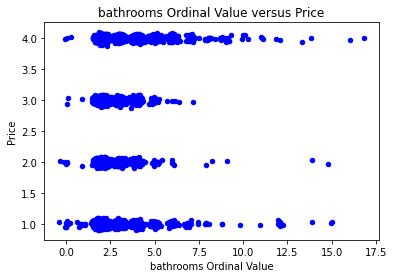

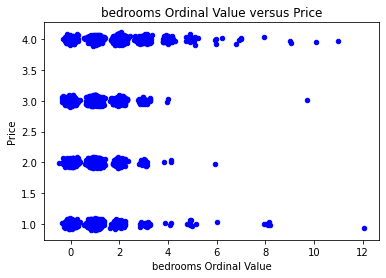

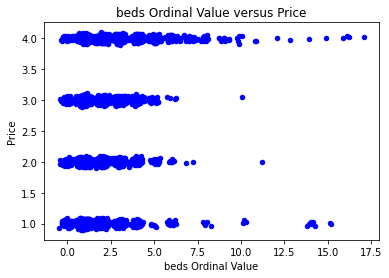

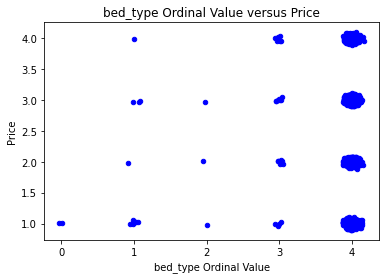

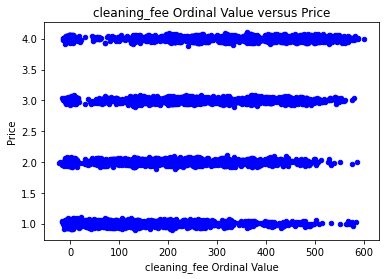

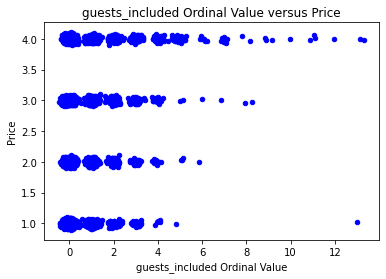

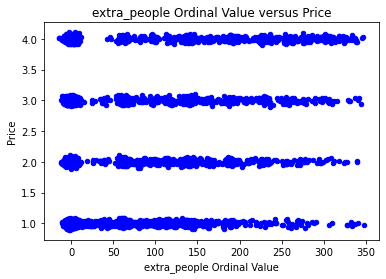

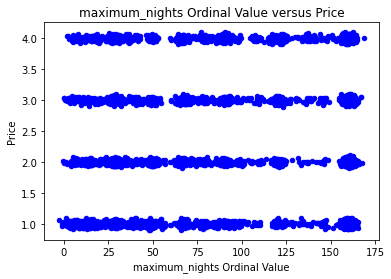

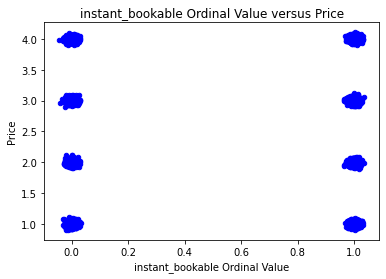

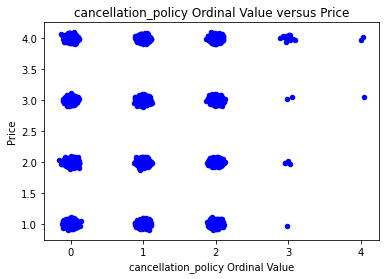

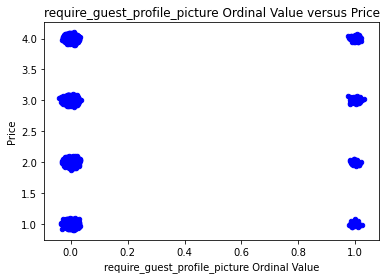

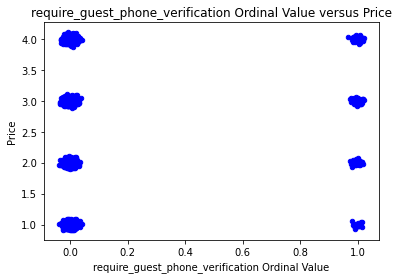

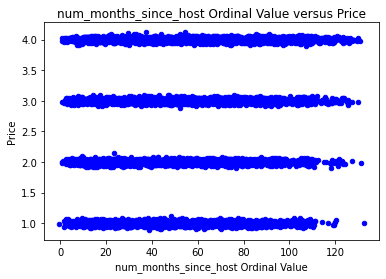

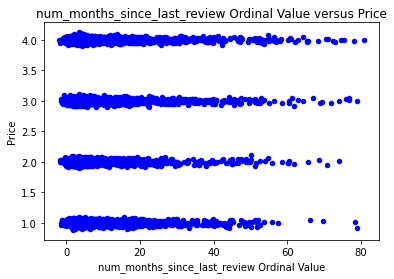

In [10]:
# A scatter plot with noise added to be able to see approximately how many points lie in each category
# Code for jitter borrowed from somewhere else online

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

jitter(X_train["beds"].astype(int), np.ravel(y_train).astype(int))
for i in range(smart_X_train.shape[1]):
    jitter(smart_X_train[:,i].astype(int), np.ravel(y_train).astype(int))
    plt.xlabel(X_train.columns[i] + str(' Ordinal Value'))
    plt.ylabel('Price')
    plt.title(X_train.columns[i] + str(' Ordinal Value versus Price'))
    plt.show()

[3.74706143e-01 2.47443058e-01 1.54289448e-01 1.33348878e-01
 5.11103943e-02 2.02345869e-02 9.05719167e-03 3.66176397e-03
 2.84546715e-03 1.35234279e-03 9.39703098e-04 7.88862865e-04
 7.52581569e-05 4.33350434e-05 3.34785933e-05 2.34638241e-05
 1.65893943e-05 1.26609888e-05 8.26396865e-06 5.65182881e-06
 3.37857311e-06 7.97781421e-08 2.66046107e-31]


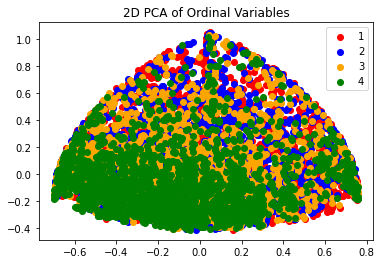

[6.88045476e-01 2.25249238e-01 2.24799282e-02 1.98792492e-02
 1.20805974e-02 8.69970962e-03 5.91679660e-03 5.38850930e-03
 4.52834792e-03 3.14579842e-03 2.63189935e-03 7.04975976e-04
 3.93446136e-04 2.42425839e-04 1.88150575e-04 1.46734414e-04
 1.12426888e-04 8.94108288e-05 5.50503832e-05 2.14732777e-05
 3.56160544e-07 1.06938293e-30]


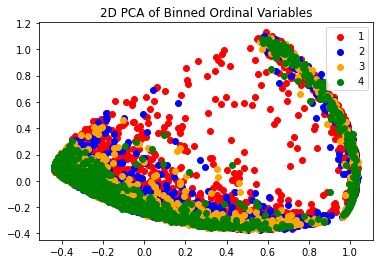

In [11]:
# Compute PCA into two dimensions just to see what the data looks like and whether it looks separable
def compute_PCA(Y, labels, title = ''):
    Y = Y - np.mean(Y, 1)[:, None]
    Y = Y/np.sqrt(np.sum(Y**2, 1))[:, None]
    pca = PCA()
    Z = pca.fit_transform(Y)
    print(pca.explained_variance_ratio_)
    plt.title("2D PCA" + title)
    plt.scatter(Z[labels == 1][:, 0], Z[labels == 1][:, 1], c = 'red', label = "1")
    plt.scatter(Z[labels == 2][:, 0], Z[labels == 2][:, 1], c = 'blue', label = "2")
    plt.scatter(Z[labels == 3][:, 0], Z[labels == 3][:, 1], c = 'orange', label = "3")
    plt.scatter(Z[labels == 4][:, 0], Z[labels == 4][:, 1], c = 'green', label = "4")
    plt.legend()
    plt.show()
    
compute_PCA(new_X_train, np.ravel(y_train), title = ' of Ordinal Variables')
compute_PCA(binned_X_train, np.ravel(y_train), title = ' of Binned Ordinal Variables')

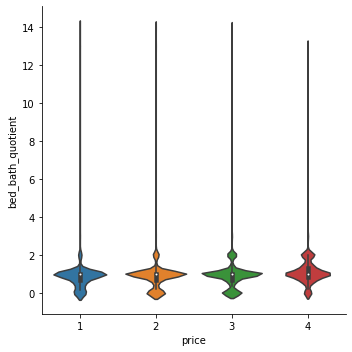

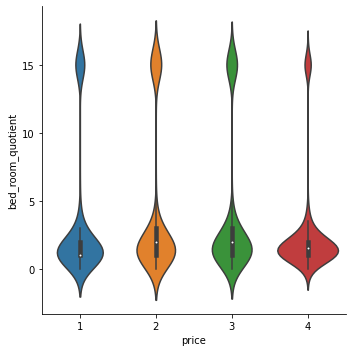

In [12]:
# Checking how good our new features look via violin plots
train_set["bed_bath_quotient"] = bed_bath_quotient
train_set["bed_room_quotient"] = bed_room_quotient
sns.catplot(x="price", y="bed_bath_quotient", kind="violin", data=train_set)
sns.catplot(x="price", y="bed_room_quotient", kind="violin", data=train_set)

In [13]:
def run_cross_validation_on_specific_forest(X, y, forest):
    curr_cv_scores = np.array([])
    curr_train_scores = np.array([])

    # Splitting the training data into folds and finding training and test data within that
    for train_index, test_index in kf.split(X):
        # X_test_fold really means the cross validation fold here
        X_train_fold, X_test_fold = X[train_index,:], X[test_index,:]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        forest.fit(X_train_fold, y_train_fold)
        y_train_predict = forest.predict(X_train_fold)
        y_test_predict = forest.predict(X_test_fold)
        #print("Test accuracy: "+ str(accuracy(y_test_predict, y_test_fold)))
        curr_cv_scores = np.append(curr_cv_scores, accuracy(y_test_predict, y_test_fold))
        curr_train_scores = np.append(curr_train_scores, accuracy(y_train_predict, y_train_fold))

    return curr_cv_scores.mean(), curr_cv_scores.std(), curr_train_scores.mean()

def run_cross_validation_on_forest(X, y, depth, n_estimators = 50, criterion = 'gini', scoring='accuracy'):
    # Get the accuracy, mean, std from the cross validation.
    if criterion == 'gini':
        forest = RandomForestClassifier(n_estimators = n_estimators, criterion = 'gini', max_depth = depth)
    elif criterion == 'entropy':
        forest = RandomForestClassifier(n_estimators = n_estimators, criterion = 'entropy', max_depth = depth)
    
    return run_cross_validation_on_specific_forest(X,y,forest)

# Function for running cross validation on random forest, adapted from HW 1
def run_cross_validation_on_forest_depth_search(X, y, tree_depths, n_estimators = 50, criterion = 'gini', scoring='accuracy'):
    # Each entry in one of these arrays corresponds to some depth
    cv_scores_std = []
    cv_scores_mean = []
    train_scores = []
    
    for depth in tree_depths:
        curr_cv_mean, curr_cv_std, curr_train_mean = run_cross_validation_on_forest(X, y, depth, n_estimators, criterion, scoring)
        
        # Update the 
        cv_scores_mean =np.append(cv_scores_mean, curr_cv_mean)
        cv_scores_std = np.append(cv_scores_std, curr_cv_std)
        train_scores = np.append(train_scores, curr_train_mean)
        
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    train_scores = np.array(train_scores)
    return cv_scores_mean, cv_scores_std, train_scores

# Function for plotting cross-validation results, borrowed from HW 1
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, train_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, train_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim([0,1])
    ax.set_xticks(depths)
    ax.legend()

# Taken from stack overflow: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
# cv_results is a 
# grid_param_1
# name_param_1 and name_param_2 are strings
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')


In [14]:
depths = range(2,32,3)

# Uses lazy ordinal encoding
lazy_cv_mean_scores, lazy_cv_std_scores, lazy_train_mean_scores = run_cross_validation_on_forest_depth_search(lazy_X_train, np.ravel(y_train), depths)
# Uses smarter ordinal encoding
smart_cv_mean_scores, smart_cv_std_scores, smart_train_mean_scores = run_cross_validation_on_forest_depth_search(smart_X_train, np.ravel(y_train), depths)
# Uses entropy splitting criteria
entropy_cv_mean_scores, entropy_cv_std_scores, entropy_train_mean_scores = run_cross_validation_on_forest_depth_search(smart_X_train, np.ravel(y_train), depths, criterion = 'entropy')
# Makes use of additional features computed
new_cv_mean_scores, new_cv_std_scores, new_train_mean_scores = run_cross_validation_on_forest_depth_search(new_X_train, np.ravel(y_train), depths)
# Tries using binned values instead of raw values
binned_cv_mean_scores, binned_cv_std_scores, binned_train_mean_scores = run_cross_validation_on_forest_depth_search(binned_X_train, np.ravel(y_train), depths)

In [15]:
# Does a quick sanity check on whether the value of max_features matters significantly
forest = RandomForestClassifier(n_estimators = 50, max_depth = 12, max_features = None)
all_features_cv_means, all_features_cv_stds, all_features_train_means = run_cross_validation_on_specific_forest(binned_X_train, np.ravel(y_train), forest)
print(all_features_cv_means)
print(all_features_train_means)
forest2 = RandomForestClassifier(n_estimators = 50, max_depth = 12, max_features = 'sqrt')
bagged_features_cv_means, bagged_features_cv_stds, bagged_features_train_means = run_cross_validation_on_specific_forest(binned_X_train, np.ravel(y_train), forest2)
print(bagged_features_cv_means)
print(bagged_features_train_means)

0.5412671145206228
0.8407448320430669
0.5413679136604701
0.83829164977138


The difference between allowing all features versus a subset of features is negligible here.

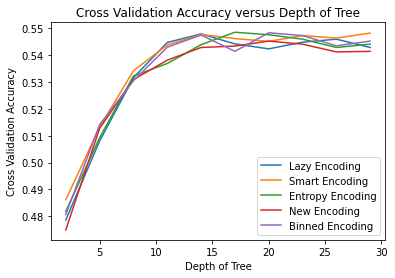

In [16]:
# Plot cross validation accuracies for methods run on differently engineered features
plt.plot(depths, lazy_cv_mean_scores, label = "Lazy Encoding") 
plt.plot(depths, smart_cv_mean_scores, label = "Smart Encoding")
plt.plot(depths, entropy_cv_mean_scores, label = "Entropy Encoding")
plt.plot(depths, new_cv_mean_scores, label = "New Encoding")
plt.plot(depths, binned_cv_mean_scores, label = "Binned Encoding")
plt.legend()
plt.title("Cross Validation Accuracy versus Depth of Tree")
plt.xlabel("Depth of Tree")
plt.ylabel("Cross Validation Accuracy")
plt.show()

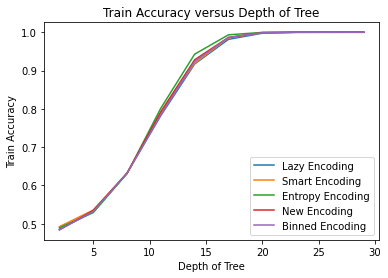

In [17]:
# Plot training accuracies
plt.plot(depths, lazy_train_mean_scores, label = "Lazy Encoding") 
plt.plot(depths, smart_train_mean_scores, label = "Smart Encoding")
plt.plot(depths, entropy_train_mean_scores, label = "Entropy Encoding")
plt.plot(depths, new_train_mean_scores, label = "New Encoding")
plt.plot(depths, binned_train_mean_scores, label = "Binned Encoding")
plt.legend()
plt.title("Train Accuracy versus Depth of Tree")
plt.xlabel("Depth of Tree")
plt.ylabel("Train Accuracy")
plt.show()

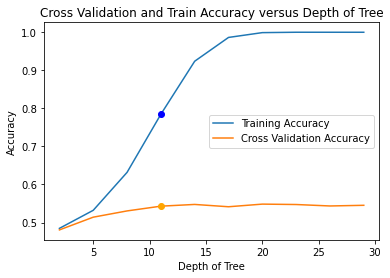

In [18]:
# Plot training versus cross validation accuracies
plt.plot(depths, binned_train_mean_scores, label = "Training Accuracy")
plt.plot(depths, binned_cv_mean_scores, label = "Cross Validation Accuracy")
plt.plot(depths[3], binned_train_mean_scores[3], marker = 'o', color = 'blue')
plt.plot(depths[3], binned_cv_mean_scores[3], marker = 'o', color = 'orange')
plt.legend()
plt.title("Cross Validation and Train Accuracy versus Depth of Tree")
plt.xlabel("Depth of Tree")
plt.ylabel("Accuracy")
plt.show()

The optimal value of depth looks to be around 11 here - cross validation levels off after that and training accuracy is overfit after that.

In [19]:
# Referenced https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
criterion = ['gini', 'entropy']
max_features = [None, 'sqrt']
max_depth = [int(x) for x in np.linspace(10,90, num=9)]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]

random_grid = {'n_estimators': n_estimators, 'criterion': criterion, 'max_features': max_features, 'max_depth':max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = kf, random_state = 671, n_jobs = -1)
rf_random.fit(smart_X_train, np.ravel(y_train))
rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'criterion': 'gini'}

In [20]:
print(pd.DataFrame.from_dict(rf_random.cv_results_).sort_values(by = 'rank_test_score').head(10))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
18       3.317818      0.119295         0.119795        0.013359   
17       6.754857      0.254439         0.222560        0.003701   
43      14.364305      0.186729         0.331348        0.006886   
29      11.912788      0.398258         0.273190        0.044975   
11      14.977011      0.202655         0.321947        0.001229   
27      46.662339      1.502877         0.239011        0.009909   
8       64.715046      0.237499         0.330734        0.004431   
1       30.654623      0.312734         0.160504        0.002203   
25       3.264774      0.192325         0.109083        0.005201   
49      34.673355      3.790501         0.278427        0.035967   

   param_n_estimators param_min_samples_split param_min_samples_leaf  \
18                150                       5                      1   
17                300                       5                      1   
43                450              

In [21]:
parameters = {'max_features': [None, 'sqrt'], 'n_estimators':[50, 100,150,300,450]}
forest = RandomForestClassifier()
forest_grid = GridSearchCV(estimator = forest, param_grid = parameters, cv = kf, n_jobs = -1)

forest_grid.fit(binned_X_train, np.ravel(y_train))

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [None, 'sqrt'],
                         'n_estimators': [50, 100, 150, 300, 450]})

In [22]:
print(pd.DataFrame.from_dict(forest_grid.cv_results_).sort_values(by = 'rank_test_score').head(10))

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9       9.474214      0.539742         0.317114        0.052867   
8       6.701304      0.108865         0.251526        0.017585   
3      25.768103      2.147315         0.225257        0.005007   
7       3.462552      0.141959         0.131447        0.017857   
4      33.712751      0.303139         0.329419        0.006676   
6       2.188350      0.104804         0.078525        0.001034   
2      11.318305      0.178619         0.112187        0.005474   
1       7.367225      0.052210         0.073129        0.001641   
5       1.098474      0.041763         0.041379        0.001350   
0       3.638546      0.015846         0.038797        0.001112   

  param_max_features param_n_estimators  \
9               sqrt                450   
8               sqrt                300   
3               None                300   
7               sqrt                150   
4               None                450   
6   

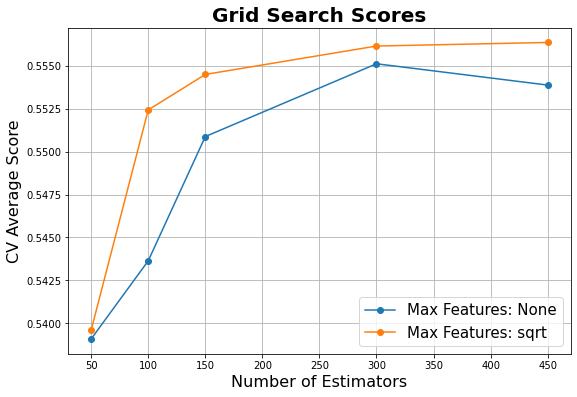

In [23]:
plt.rcParams["figure.figsize"] = (9,6)
plot_grid_search(forest_grid.cv_results_, parameters['n_estimators'], parameters['max_features'], 'Number of Estimators', 'Max Features')

In [24]:
start = time.time()
forest = RandomForestClassifier(n_estimators = 150, max_depth = 11, max_features = 'sqrt', criterion = 'entropy', min_samples_split = 5, random_state = 671)
fit_start = time.time()
forest.fit(smart_X_train, np.ravel(y_train))
fit_end = time.time()
print("Fit time: " + str(fit_end - fit_start))
forest_predict = forest.predict(smart_X_train)
end = time.time()
print("Total time: " + str(end-start))

print(accuracy(y_train, forest_predict))
confusion_matrix(y_train, forest_predict)

final_model_cv_mean, final_model_cv_std, final_model_train_mean = run_cross_validation_on_specific_forest(binned_X_train, np.ravel(y_train), forest)
print(final_model_cv_mean)
print(final_model_train_mean)

Fit time: 2.9950551986694336
Total time: 3.217597007751465
0.7622146472471852
0.5473608758538594
0.7849655002694353


In [25]:
coarse_weight_vec = [1,1,0.75,0.75,1,1,1,1,0.75,0.75,0.5,1,1,1,0.5,0.75,0.5,0.75,0.5,1,0.5,0.5]
print(X_train.dtypes)
print(coarse_X_train.dtypes)


neighbourhood                        object
room_type                            object
minimum_nights                        int64
number_of_reviews                     int64
reviews_per_month                   float64
calculated_host_listings_count        int64
availability_365                      int64
host_is_superhost                    object
bathrooms                           float64
bedrooms                              int64
beds                                  int64
bed_type                             object
cleaning_fee                          int64
guests_included                       int64
extra_people                          int64
maximum_nights                        int64
instant_bookable                     object
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
num_months_since_host                 int64
num_months_since_last_review          int64
dtype: object
neighbourhood     

In [26]:
# This computation is extremely slow but we only ever have to do it once
# Done using the gower package, which automatically computes gower distance
start = time.time()
distance_matrix = gower.gower_matrix(X_train)
end = time.time()
print("Time elapsed: "+ str(end-start))

Time elapsed: 307.6202278137207


In [27]:
# Same thing but run on our binned data
start = time.time()
coarse_distance_matrix = gower.gower_matrix(coarse_X_train)
end = time.time()
print("Time elapsed: "+ str(end-start))

Time elapsed: 321.0601966381073


In [28]:
# Tailored to use the distance matrix computed under gower distance
def run_knn_cross_validation(X, y, distance_matrix, n_neighbors, weight_type = 'uniform', scoring = 'accuracy'):
    
    # Get the accuracy, mean, std from the cross validation.
    curr_cv_scores = np.array([])
    curr_train_scores = np.array([])
    

    # Splitting the training data into folds and finding training and test data within that
    for train_index, test_index in kf.split(X):
        
        # X_test_fold really means the cross validation fold here, compute distances to training samples
        X_train_fold = distance_matrix[train_index,:][:,train_index]
        X_test_fold = distance_matrix[test_index, :][:,train_index]
        y_train_fold, y_test_fold = np.ravel(y_train)[train_index], np.ravel(y_train)[test_index]
        
        # Uniform weights all neighbors the same, weighted gives higher weight to those closer to the original point
        if weight_type == 'uniform':
            knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors = n_neighbors, weights = 'uniform', metric = 'precomputed')
        if weight_type == 'weighted':
            knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors = n_neighbors, weights = 'distance', metric = 'precomputed')
        
        start = time.time()
        knn.fit(X_train_fold, y_train_fold)
        end = time.time()
        print("Time elapsed: "+ str(end-start))
        
        y_train_predict = knn.predict(X_train_fold)
        y_test_predict = knn.predict(X_test_fold)
        curr_cv_scores = np.append(curr_cv_scores, accuracy(y_test_predict, y_test_fold))
        curr_train_scores = np.append(curr_train_scores, accuracy(y_train_predict, y_train_fold))
        
        
    return curr_cv_scores.mean(), curr_cv_scores.std(), curr_train_scores.mean()

# Search over a list of values for n_neighbors
def run_knn_cross_validation_neighbors_search(X, y, distance_matrix, n_neighbors_list, weight_type = 'uniform', scoring = 'accuracy'):
    # Store train means, cv means and stddevs, over all values for n_neighbors stored in n_neighbors_list
    cv_scores_std = []
    cv_scores_mean = []
    train_scores = []
    
    for n in n_neighbors_list:
        curr_cv_mean, curr_cv_std, curr_train_mean = run_knn_cross_validation(X, y, distance_matrix, n, weight_type, scoring)
        cv_scores_mean = np.append(cv_scores_mean, curr_cv_mean)
        cv_scores_std = np.append(cv_scores_std, curr_cv_std)
        train_scores = np.append(train_scores, curr_train_mean)
        
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    train_scores = np.array(train_scores)
    return cv_scores_mean, cv_scores_std, train_scores

# Function for plotting cross-validation results, borrowed from HW 1
def plot_cross_validation_on_knn(neighbor_counts, cv_scores_mean, cv_scores_std, train_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(neighbor_counts, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(neighbor_counts, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(neighbor_counts, train_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Number of Neighbors', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim([0,1])
    ax.set_xticks(neighbor_counts)
    ax.legend()

    

In [29]:
# Compute cross validation for different values of k
k_vals = [3,5,7,9,11,13,17, 21, 31, 41,51, 89]
unnormalized_val_scores_mean, unnormalized_val_scores_std, unnormalized_train_scores_mean = run_knn_cross_validation_neighbors_search(X_train, y_train, distance_matrix, k_vals, weight_type = 'uniform')
val_scores_mean, val_scores_std, train_scores_mean = run_knn_cross_validation_neighbors_search(X_train, y_train, coarse_distance_matrix, k_vals, weight_type = 'uniform')
weighted_val_scores_mean, weighted_val_scores_std, weighted_train_scores_mean = run_knn_cross_validation_neighbors_search(X_train, y_train, distance_matrix, k_vals, weight_type = 'weighted')


Time elapsed: 0.12750673294067383
Time elapsed: 0.13099098205566406
Time elapsed: 0.12702155113220215
Time elapsed: 0.12952136993408203
Time elapsed: 0.21877431869506836
Time elapsed: 0.17479228973388672
Time elapsed: 0.1659395694732666
Time elapsed: 0.12653160095214844
Time elapsed: 0.12994861602783203
Time elapsed: 0.12825846672058105
Time elapsed: 0.12939858436584473
Time elapsed: 0.12984991073608398
Time elapsed: 0.1277785301208496
Time elapsed: 0.12966156005859375
Time elapsed: 0.12995171546936035
Time elapsed: 0.128432035446167
Time elapsed: 0.13121938705444336
Time elapsed: 0.12899327278137207
Time elapsed: 0.13045954704284668
Time elapsed: 0.12925124168395996
Time elapsed: 0.13090729713439941
Time elapsed: 0.13077592849731445
Time elapsed: 0.1271066665649414
Time elapsed: 0.13205933570861816
Time elapsed: 0.1301875114440918
Time elapsed: 0.12882757186889648
Time elapsed: 0.132706880569458
Time elapsed: 0.12796545028686523
Time elapsed: 0.12983012199401855
Time elapsed: 0.148737

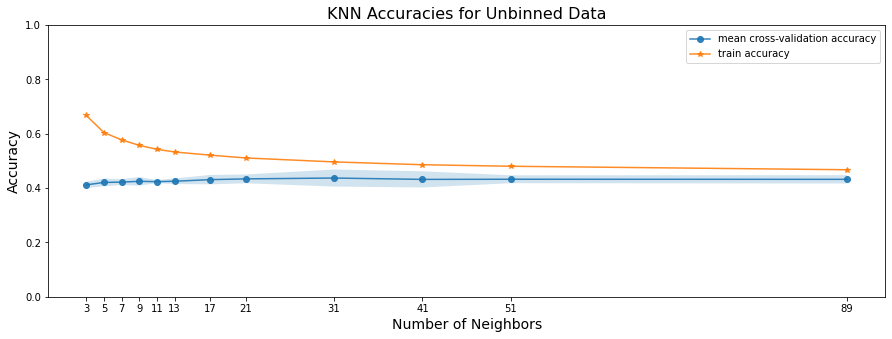

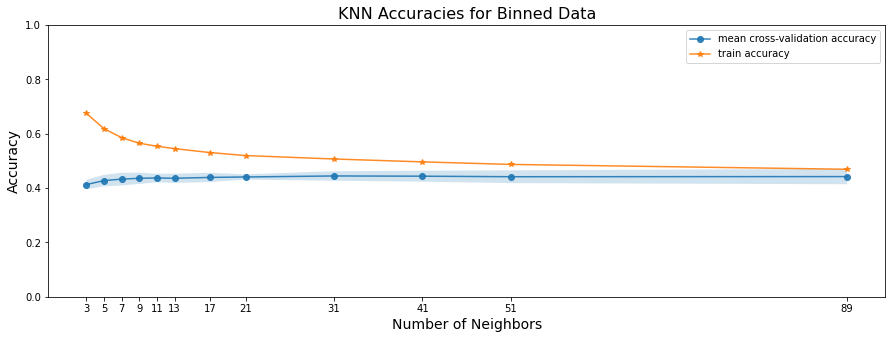

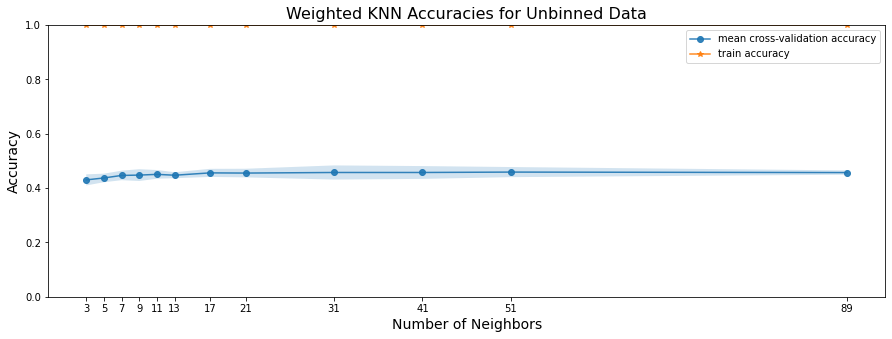

In [30]:
# Plot training and validation accuracy for different hyperparameters
plot_cross_validation_on_knn(k_vals, unnormalized_val_scores_mean, unnormalized_val_scores_std, unnormalized_train_scores_mean, title = 'KNN Accuracies for Unbinned Data')
plot_cross_validation_on_knn(k_vals, val_scores_mean, val_scores_std, train_scores_mean, title = 'KNN Accuracies for Binned Data')
plot_cross_validation_on_knn(k_vals, weighted_val_scores_mean, weighted_val_scores_std, weighted_train_scores_mean, title = 'Weighted KNN Accuracies for Unbinned Data')


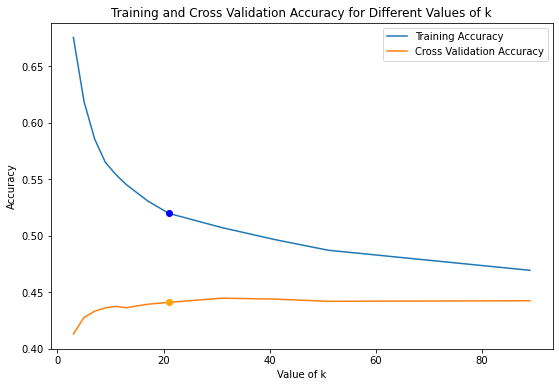

In [31]:
# Plot training and cross validation accuracy across k
plt.plot(k_vals, train_scores_mean, label = "Training Accuracy") 
plt.plot(k_vals, val_scores_mean, label = 'Cross Validation Accuracy')
plt.plot(k_vals[7], train_scores_mean[7], marker = 'o', color = 'blue')
plt.plot(k_vals[7], val_scores_mean[7], marker = 'o', color = 'orange')
plt.legend()
plt.xlabel('Value of k')
plt.ylabel('Accuracy')
plt.title('Training and Cross Validation Accuracy for Different Values of k')
plt.show()

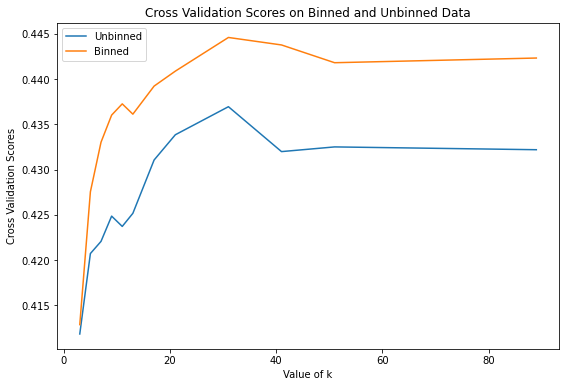

In [32]:
# Plot cross validation scores on binned and unbinned data
plt.plot(k_vals, unnormalized_val_scores_mean, label = "Unbinned") 
plt.plot(k_vals, val_scores_mean, label = "Binned")
plt.legend()
plt.xlabel('Value of k')
plt.ylabel('Cross Validation Scores')
plt.title('Cross Validation Scores on Binned and Unbinned Data')
plt.show()

In [33]:
# Check training time of final knn model
start = time.time()
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 21, weights = 'uniform', metric = 'precomputed')

fit_start = time.time()
knn.fit(distance_matrix, np.ravel(y_train))
fit_end = time.time()
print("Fit Time: "+ str(fit_end-fit_start))

knn_predict = knn.predict(distance_matrix)
end = time.time()
print("Total Time: " + str(end-start))

Fit Time: 0.21572327613830566
Total Time: 2.272226572036743


In [34]:
# Compute and print statistics for final knn model
final_cv_mean, final_cv_std, final_train_mean = run_knn_cross_validation(X_train, y_train, distance_matrix, n_neighbors = 21, weight_type = 'uniform')

Time elapsed: 0.13142848014831543
Time elapsed: 0.13182759284973145
Time elapsed: 0.12955188751220703
Time elapsed: 0.13260483741760254
Time elapsed: 0.13274621963500977


In [35]:
print(final_cv_mean)
print(final_cv_std)
print(final_train_mean)

0.43383869790977786
0.008104448281702856
0.5108975532068143


In [36]:
# Submission Code for Unbinned Encoded Data

final_encoder = OrdinalEncoder(categories = [
    # neighbourhood - not sure how to meaningfully order these - maybe use a one-hot encoder for this honestly
    X_train.neighbourhood.unique(),
    # room_type
    ["Shared room", "Private room", "Hotel room", "Entire home/apt"], 
    # minimum_nights
    np.sort(X_test.minimum_nights.unique()),
    # number_of_reviews,
    np.sort(X_test.number_of_reviews.unique()),
    # last_review
    # Note: This is buggy and should be dealt with separately
    np.sort(X_test.last_review.unique()),
    # reviews_per_month
    np.sort(X_test.reviews_per_month.unique()),
    # calculated_host_listings_count
    np.sort(X_test.calculated_host_listings_count.unique()),
    # availability_365
    np.sort(X_test.availability_365.unique()),
    # host_since
    np.sort(X_test.host_since.unique()),
    # host_is_superhost
    ['f', 't'],
    # bathrooms
    np.sort(X_test.bathrooms.unique()),
    # bedrooms
    np.sort(X_test.bedrooms.unique()),
    # beds
    np.sort(X_test.beds.unique()),
    # bed_type
    ["Airbed", "Futon", "Couch", "Pull-out Sofa", "Real Bed"],
    # cleaning_fee
    np.sort(X_test.cleaning_fee.unique()),
    # guests_included
    np.sort(X_test.guests_included.unique()),
    # extra_people
    np.sort(X_test.extra_people.unique()),
    # maximum_nights
    np.sort(X_test.maximum_nights.unique()),
    # instant_bookable
    ['f', 't'],
    # cancellation_policy
    ['flexible', 'moderate', 'strict_14_with_grace_period', 'super_strict_30','super_strict_60'],
    # require_guest_profile_picture
    ["f", "t"],
    # require_guest_phone_verification
    ["f","t"]  
])
final_encoder.fit(X_test)
smart_X_test = final_encoder.transform(X_test)

# Depth, number of classifiers chosen from cross-validation search above
forest = RandomForestClassifier(n_estimators = 450, max_depth = 15, max_depth = )
forest.fit(smart_X_train, np.ravel(y_train))
y_predict = forest.predict(smart_X_test)

# Store into csv
my_submission = pd.DataFrame({'id': test_set.id, 'price': y_predict})
my_submission.to_csv('submission_2.csv', index = False)

SyntaxError: invalid syntax (<ipython-input-36-dd2f6873f76e>, line 54)

In [37]:
# Submission block 
coarse_X_test = X_test.copy()
coarse_X_test['binned_min_nights'] = pd.to_numeric(pd.cut(coarse_X_test['minimum_nights'], bins=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,21,28,35,42,60,90, 120, 150, 180, 365, max(coarse_X_test.minimum_nights.max(),366)], labels= range(26)))
coarse_X_test['binned_num_reviews'] = pd.to_numeric(pd.cut(coarse_X_test['number_of_reviews'], bins=[-1, 0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120,140,160,180,200,225,250,275,300,333,367,400,450,500, max(coarse_X_test.number_of_reviews.max(), 501)], labels = range(39)))
coarse_X_test['binned_last_review'] = pd.to_numeric(pd.cut(coarse_X_test['num_months_since_last_review'], bins=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,14,16,18,20,22,24,27,30,33,36,40,44,48,54,60,66,72,78,84,96,108,max(coarse_X_test.num_months_since_last_review.max(),109)], labels= range(35)))
coarse_X_test['binned_host_listings'] = pd.to_numeric(pd.cut(coarse_X_test['calculated_host_listings_count'], bins=[-1,0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,75, 100, max(coarse_X_test.calculated_host_listings_count.max(),101)], labels= range(20)))
coarse_X_test['binned_availability_365'] = pd.to_numeric(pd.cut(coarse_X_test['availability_365'], bins = [-1,0,7,14,30,60,90, 120,150, 180,240,300,330,350,max(coarse_X_test.availability_365.max(),351)], labels = range(14)))
coarse_X_test['binned_host_since'] = pd.to_numeric(pd.cut(coarse_X_test['num_months_since_host'], bins = [-1,0,1,2,3,4,5,6,7,8,9,10,11,12,14,16,18,20,22,24,27,30,33,36,40,44,48,54,60,66,72,78,84,96,108,120,132,max(coarse_X_test.num_months_since_host.max(),133)], labels = range(37)))
coarse_X_test['binned_extra_people'] = pd.to_numeric(pd.cut(coarse_X_test['extra_people'], bins = [-1,0,100,200,300,400,500,600,700,800,900,1000,1250,1500,1750,2000,3000,4000,5000,10000,max(coarse_X_test.extra_people.max(),10001)], labels = range(20)))
coarse_X_test['binned_maximum_nights'] = pd.to_numeric(pd.cut(coarse_X_test['maximum_nights'], bins = [-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,21,30,60,90,120,150,180,365,730,1095,1460,1825,max(coarse_X_test.maximum_nights.max(),1826)], labels = range(28)))
coarse_X_test = coarse_X_test.drop(columns = ['minimum_nights', 'number_of_reviews', 'num_months_since_last_review', 'calculated_host_listings_count', 'availability_365', 'num_months_since_host', 'extra_people', 'maximum_nights'])


binned_test_encoder = OrdinalEncoder(categories = [
    # neighbourhood - no sorting performed
    coarse_X_test.neighbourhood.unique(),
    # room_type
    ["Shared room", "Private room", "Hotel room", "Entire home/apt"], 
    # reviews_per_month
    np.sort(coarse_X_test.reviews_per_month.unique()),
    # host_is_superhost
    ['f', 't'],
    # bathrooms
    np.sort(coarse_X_test.bathrooms.unique()),
    # bedrooms
    np.sort(coarse_X_test.bedrooms.unique()),
    # beds
    np.sort(coarse_X_test.beds.unique()),
    # bed_type
    ["Airbed", "Futon", "Couch", "Pull-out Sofa", "Real Bed"],
    # cleaning_fee
    np.sort(coarse_X_test.cleaning_fee.unique()),
    # guests_included
    np.sort(coarse_X_test.guests_included.unique()),
    # instant_bookable
    ['f', 't'],
    # cancellation_policy
    ['flexible', 'moderate', 'strict_14_with_grace_period', 'super_strict_30','super_strict_60'],
    # require_guest_profile_picture
    ["f", "t"],
    # require_guest_phone_verification
    ["f","t"],
    # binned_min_nights
    np.sort(coarse_X_test.binned_min_nights.unique()),
    # binned_num_reviews
    np.sort(coarse_X_test.binned_num_reviews.unique()),
    # binned_last_review
    np.sort(coarse_X_test.binned_last_review.unique()),
    # binned_host_listings
    np.sort(coarse_X_test.binned_host_listings.unique()),
    # binned_availability_365
    np.sort(coarse_X_test.binned_availability_365.unique()),
    # binned_host_since
    np.sort(coarse_X_test.binned_host_since.unique()),
    # binned_extra_people
    np.sort(coarse_X_test.binned_extra_people.unique()),
    # maximum_nights
    np.sort(coarse_X_test.binned_maximum_nights.unique())
])

binned_test_encoder.fit(coarse_X_test)
binned_X_test = binned_test_encoder.transform(coarse_X_test)

# Hyperparameters chosen from cross-validation search above
forest = RandomForestClassifier(n_estimators = 150, criterion = 'entropy', max_depth = 11, max_features = 'sqrt', min_samples_split = 5)
forest.fit(binned_X_train, np.ravel(y_train))
y_predict = forest.predict(binned_X_test)

# Store into csv
my_submission = pd.DataFrame({'id': test_set.id, 'price': y_predict})
my_submission.to_csv('submission_3.csv', index = False)

In [38]:
'''
# An attempt to use boosted decision trees, now deprecated
estimators = [25,50,100,150,200,250]
lazy_mean_accuracies = []
smart_mean_accuracies = []

for n in estimators:
    lazy_boosted_stumps = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = n)
    smart_boosted_stumps = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = n)
    lazy_mean_accuracies.append(np.mean(cross_val_score(lazy_boosted_stumps, lazy_X_train, np.ravel(y_train), cv=5)))
    smart_mean_accuracies.append(np.mean(cross_val_score(smart_boosted_stumps, smart_X_train, np.ravel(y_train), cv=5)))

plt.plot(estimators, lazy_mean_accuracies, label = "Lazy encoding" )
plt.plot(estimators, smart_mean_accuracies, label = "Smart encoding")
plt.legend()

boosted_stumps = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = 150)
boosted_stumps.fit(smart_X_train, np.ravel(y_train))
boost_predict = boosted_stumps.predict(smart_X_train)
'''

'\n# An attempt to use boosted decision trees, now deprecated\nestimators = [25,50,100,150,200,250]\nlazy_mean_accuracies = []\nsmart_mean_accuracies = []\n\nfor n in estimators:\n    lazy_boosted_stumps = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = n)\n    smart_boosted_stumps = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = n)\n    lazy_mean_accuracies.append(np.mean(cross_val_score(lazy_boosted_stumps, lazy_X_train, np.ravel(y_train), cv=5)))\n    smart_mean_accuracies.append(np.mean(cross_val_score(smart_boosted_stumps, smart_X_train, np.ravel(y_train), cv=5)))\n\nplt.plot(estimators, lazy_mean_accuracies, label = "Lazy encoding" )\nplt.plot(estimators, smart_mean_accuracies, label = "Smart encoding")\nplt.legend()\n\nboosted_stumps = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = 150)\nboosted_stumps.fit(smart_X_train, np.ravel(y_train))\nboost_predict = boosted_stumps.predict(smart_X_train)\n'

In [39]:
'''
# Custom code to compute gower distance manually - now deprecated

# Get random weights for use in computing the gowers distance manually
def get_random_weights(length, seed = 671):
    seed(seed)
    return rand(length)

# Assume x and y are vectors of the given form
def gowers_distance(x_num, x_cat, y_num, y_cat, weight_vec, weight_type = 'unweighted', seed = 671):
    if weight_type == "unweighted":
        weight_vec = [1] * (len(x_num)+len(x_cat))
    if weight_type == "random":
        weight_vec = get_random_weights(len(x_num)+len(x_cat), seed = seed)
    distance = 0
    for i in range(len(x_num)):
        distance += np.abs(x_num[i] - y_num[i]) * weight_vec[i]
    for i in range(len(x_cat)):
        distance += int((x_cat[i] == y_cat[i])) * weight_vec[len(x_num)+i]

    return distance

# X a matrix, each row an observation 
def get_gowers_distance_matrix(X, weight_vec, weight_type = 'unweighted', seed = 671):
    numerical_variables = X.select_dtypes(include = 'number')
    cat_variables = X.select_dtypes(exclude = 'number')
    print(numerical_variables.columns)
    print(cat_variables.columns)
    min_max_scaler = MinMaxScaler()
    scaled_numerical = min_max_scaler.fit_transform(numerical_variables)
    
    distance_matrix = np.empty([X.shape[0], X.shape[0]])
    for row1 in range(distance_matrix.shape[0]):
        for row2 in range(row1, distance_matrix.shape[0]):
            if row1 == row2:
                distance_matrix[row1][row2] = 0
            else:
                distance_matrix[row1][row2] = gowers_distance(scaled_numerical[row1,:], cat_variables.iloc[row1,:], scaled_numerical[row2,:], cat_variables.iloc[row2,:], weight_vec = weight_vec, seed = seed)
    distance_matrix = distance_matrix + np.transpose(distance_matrix)
    return distance_matrix
get_gowers_distance_matrix(coarse_X_train, weight_vec = [1] * coarse_X_train.shape[0])

# Same thing but run on our binned data and weighted
start = time.time()
weighted_coarse_distance_matrix = gower.gower_matrix(coarse_X_train, weight = coarse_weight_vec)
end = time.time()
print("Time elapsed: "+ str(end-start))
wght_dist_cv_mean, wght_dist_cv_std, wght_dist_train_mean = run_knn_cross_validation_neighbors_search(X_train, y_train, weighted_coarse_distance_matrix, k_vals, weight_type = 'uniform')
plot_cross_validation_on_knn(k_vals, wght_dist_cv_mean, wght_dist_cv_std, wght_dist_train_mean, title = 'KNN Accuracies for Binned Weighted Gower Matrix')
plt.plot(k_vals, wght_dist_cv_mean, label = 'Weighted Gower')
'''

'\n# Custom code to compute gower distance manually - now deprecated\n\n# Get random weights for use in computing the gowers distance manually\ndef get_random_weights(length, seed = 671):\n    seed(seed)\n    return rand(length)\n\n# Assume x and y are vectors of the given form\ndef gowers_distance(x_num, x_cat, y_num, y_cat, weight_vec, weight_type = \'unweighted\', seed = 671):\n    if weight_type == "unweighted":\n        weight_vec = [1] * (len(x_num)+len(x_cat))\n    if weight_type == "random":\n        weight_vec = get_random_weights(len(x_num)+len(x_cat), seed = seed)\n    distance = 0\n    for i in range(len(x_num)):\n        distance += np.abs(x_num[i] - y_num[i]) * weight_vec[i]\n    for i in range(len(x_cat)):\n        distance += int((x_cat[i] == y_cat[i])) * weight_vec[len(x_num)+i]\n\n    return distance\n\n# X a matrix, each row an observation \ndef get_gowers_distance_matrix(X, weight_vec, weight_type = \'unweighted\', seed = 671):\n    numerical_variables = X.select_dt

In [40]:
'''
# MIXED MODEL - just aggregate predictions and try that
# Mix a random forest on smart_X_train, a random forest on coarse_X_train, and a KNN on weighted Gower matrix
def run_cross_validation_mixed_model(X1, X2, y, forest1, forest2, knn, distance_matrix, scoring='accuracy'):
    # Get the accuracy, mean, std from the cross validation.
    curr_cv_scores = np.array([])
    curr_train_scores = np.array([])

    # Splitting the training data into folds and finding training and test data within that
    for train_index, test_index in kf.split(X):
        # X_test_fold really means the cross validation fold here
        X1_train_fold, X1_test_fold = X1[train_index,:], X1[test_index,:]
        X2_train_fold, X2_test_fold = X2[train_index,:], X2[test_index,:]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        
        knn_train_fold = distance_matrix[train_index,:][:,train_index]
        knn_test_fold = distance_matrix[test_index, :][:,train_index]
        
        forest1.fit(X1_train_fold, y_train_fold)
        forest2.fit(X2_train_fold, y_train_fold)
        knn.fit(knn_train_fold, y_train_fold)
        
        forest1_train_predict = forest1.predict(X1_train_fold)
        forest2_train_predict = forest2.predict(X2_train_fold)
        knn_train_predict = knn.predict(knn_train_fold)
        
        forest1_test_predict = forest1.predict(X1_test_fold)
        forest2_test_predict = forest2.predict(X2_test_fold)
        knn_test_predict = knn.predict(knn_test_fold)
        
        y_train_predict = np.mean([forest1_train_predict, forest2_train_predict, knn_train_predict], axis = 0)
        y_test_predict = np.mean([forest1_test_predict, forest2_test_predict, knn_test_predict], axis = 0)
        
        curr_cv_scores = np.append(curr_cv_scores, accuracy(y_test_predict, y_test_fold))
        curr_train_scores = np.append(curr_train_scores, accuracy(y_train_predict, y_train_fold))

    return curr_cv_scores.mean(), curr_cv_scores.std(), curr_train_scores.mean()

forest1 = RandomForestClassifier(n_estimators = 450, max_depth = 90)
forest2 = RandomForestClassifier(n_estimators = 450, max_depth = 20)
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 7, weights = 'uniform', metric = 'precomputed')
'''

"\n# MIXED MODEL - just aggregate predictions and try that\n# Mix a random forest on smart_X_train, a random forest on coarse_X_train, and a KNN on weighted Gower matrix\ndef run_cross_validation_mixed_model(X1, X2, y, forest1, forest2, knn, distance_matrix, scoring='accuracy'):\n    # Get the accuracy, mean, std from the cross validation.\n    curr_cv_scores = np.array([])\n    curr_train_scores = np.array([])\n\n    # Splitting the training data into folds and finding training and test data within that\n    for train_index, test_index in kf.split(X):\n        # X_test_fold really means the cross validation fold here\n        X1_train_fold, X1_test_fold = X1[train_index,:], X1[test_index,:]\n        X2_train_fold, X2_test_fold = X2[train_index,:], X2[test_index,:]\n        y_train_fold, y_test_fold = y[train_index], y[test_index]\n        \n        knn_train_fold = distance_matrix[train_index,:][:,train_index]\n        knn_test_fold = distance_matrix[test_index, :][:,train_index]\n   